# Integrate and plot sound, environmental, and climatology data

In [1]:
from pathlib import Path
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from datetime import datetime, timedelta
import hvplot.pandas
from shapely import wkt, geometry
import geopandas as gpd

In [2]:
# Supress warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

## Set sound and environmental dataset variables

Find variables by exploring https://soundcoop.portal.axds.co.

In [4]:
erddap_dataset = 'gov-ndbc-44027'
sound_dataset = 'PManan'
max_days = 20
start_date_time = '2021-10-03T06:27:12.419'
end_date_time = '2021-10-09T04:39:17.420'
min_frequency = 21
max_frequency = 24000

In [5]:
# Update end_date_time if defined temporal range exceeds max_days
time_delta = datetime.fromisoformat(end_date_time) - datetime.fromisoformat(start_date_time)
if time_delta.days > max_days:
    end_date_time = str(datetime.fromisoformat(start_date_time) + timedelta(days=max_days))
    print(f'end_date_time updated to {end_date_time}')

## Read in and clean up sound data

In [6]:
# Define file paths -- can be a string glob or list of explicit paths
sound_paths = '~/.local/share/soundcoop/*.nc'

In [7]:
# Read in data, dropping variables that are sometimes inconsistent across files to 
# prevent open_mfdataset from complaining
sound_ds = xr.open_mfdataset(
    sound_paths,
    drop_variables=['psd_image_colormap', 'psd_image', 'percentile_image', 'percentile_image_colormap'],
    engine='netcdf4'
)

# Filter data by defined temporal and frequency ranges
sound_ds = sound_ds.sel(
    time=slice(start_date_time, end_date_time),
    frequency=slice(min_frequency, max_frequency)
)

# Remove data flagged as low quality
if hasattr(sound_ds, 'quality_flag'):
    sound_ds['psd'] = sound_ds.psd.where(sound_ds.quality_flag.isin([1, 2, 3]))

sound_ds

<xarray.Dataset> Size: 1GB
Dimensions:             (time: 8533, frequency: 2157, cal_frequency: 3206)
Coordinates:
  * time                (time) datetime64[ns] 68kB 2021-10-03T06:28:00 ... 20...
  * frequency           (frequency) float64 17kB 21.0 22.0 ... 2.396e+04 2.4e+04
  * cal_frequency       (cal_frequency) float64 26kB 0.0 1.0 ... 2.56e+05
Data variables:
    timestamp           (time) timedelta64[ns] 68kB dask.array<chunksize=(1053,), meta=np.ndarray>
    effort              (time) timedelta64[ns] 68kB dask.array<chunksize=(1053,), meta=np.ndarray>
    psd                 (time, frequency) float64 147MB dask.array<chunksize=(1053, 2157), meta=np.ndarray>
    quality_flag        (time, frequency) int8 18MB dask.array<chunksize=(1053, 2157), meta=np.ndarray>
    analog_sensitivity  (time, cal_frequency) float64 219MB dask.array<chunksize=(1053, 3206), meta=np.ndarray>
    preamp_gain         (time, cal_frequency) int64 219MB dask.array<chunksize=(1053, 3206), meta=np.ndarray>
    recorder_gain       (time, cal_frequency) float64 219MB dask.array<chunksize=(1053, 3206), meta=np.ndarray>
    sensor_sensitivity  (time, cal_frequency) float64 219MB dask.array<chunksize=(1053, 3206), meta=np.ndarray>
Attributes: (12/35)
    acknowledgement:                             These products support the P...
    comment:                                     Data quality: Good 2021-07-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Timothy Rowell, Christopher ...
    creator_role:                                Principal Investigator
    date_created:                                2023-11-29
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                48000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:                             1970-01-01 00:00:00

## Download and wrangle environmental data

In [8]:
erddap_base_url = 'https://erddap.sensors.ioos.us/erddap'

In [9]:
# Get environmental sensor station lat/lon for use in mapping and querying water temperature climatology data
erddap_metadata_url = f'{erddap_base_url}/info/{erddap_dataset}/index.csv'
env_metadata_df = pd.read_csv(erddap_metadata_url)

env_station_x = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lon_min']['Value'].item()
env_station_y = env_metadata_df.loc[env_metadata_df['Attribute Name'] == 'geospatial_lat_min']['Value'].item()

In [10]:
# Grab the same time range covered by the sound data
time_start = np.datetime_as_string(sound_ds.time.min().to_pandas())
time_end = np.datetime_as_string(sound_ds.time.max().to_pandas())

wind_var = 'wind_speed'
swt_var = 'sea_surface_temperature'
wave_var = 'sea_surface_wave_significant_height'
anomaly_var = 'swt_anomaly'

erddap_dataset_url = (
    f'{erddap_base_url}/tabledap/{erddap_dataset}.csv'
    f'?time,{wind_var},{swt_var},{wave_var}&time>={time_start}&time<={time_end}'
)

In [11]:
env_df = pd.read_csv(
    erddap_dataset_url,
    skiprows=[1]  # The second row (index 1) are the column units, which we don't need
)

In [12]:
# Format the time field and set it as the index
env_df['time'] = pd.to_datetime(env_df['time'])
env_df = env_df.set_index('time').sort_index()
env_df

,wind_speed,sea_surface_temperature,sea_surface_wave_significant_height
time,,,
2021-10-03 06:50:00+00:00,5.3,12.3,1.33
2021-10-03 07:50:00+00:00,4.8,12.3,1.18
2021-10-03 08:50:00+00:00,3.0,12.4,1.19
2021-10-03 09:50:00+00:00,4.0,12.4,1.23
2021-10-03 10:50:00+00:00,4.1,12.4,1.48
...,...,...,...
2021-10-08 23:50:00+00:00,10.5,13.8,1.08
2021-10-09 00:50:00+00:00,9.5,13.8,1.14
2021-10-09 01:50:00+00:00,10.1,13.8,1.04


In [13]:
# Save CSV of environmental data
env_df.to_csv(f'env_df_{erddap_dataset}.csv')

## Map station locations

In [14]:
sound_station_pt = wkt.loads(sound_ds.attrs['geospatial_bounds'])

# Some statoins (e.g. PManan) have their WKT coordinates reversed -- should be x, y (long, lat)
if sound_station_pt.x > 0:
    sound_station_x = sound_station_pt.y
    sound_station_y = sound_station_pt.x
else:
    sound_station_x = sound_station_pt.x
    sound_station_y = sound_station_pt.y


In [15]:
stations_gdf = gpd.GeoDataFrame(
    {
        'station': [f'{sound_dataset}', f'{erddap_dataset}'],
        'geometry': [
            geometry.Point(sound_station_x, sound_station_y),
            geometry.Point(env_station_x, env_station_y)
        ]
    },
    crs='epsg:4326'
)

In [16]:
stations_gdf.hvplot(color='station', size=100, geo=True, tiles=True, frame_width=700, frame_height=500)

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]   (station)

## Merge sound and environmental data

In [17]:
# Temporal resolution to which we'll resample the sound and environmental data
# in order to merge them and plot them against each other
temporal_resolution = 'h'

In [18]:
# Convert env_df to an Xarray Dataset so it can be merged with the sound data
env_ds = env_df.to_xarray()
env_ds['time'] = pd.DatetimeIndex(env_ds['time'].values)

In [19]:
# Resample sound and environmental data and merge in to a single Xarray Dataset
ds = xr.merge([
    sound_ds.psd.resample(time=temporal_resolution).median(),
    env_ds.resample(time=temporal_resolution).mean()
])
ds

<xarray.Dataset> Size: 2MB
Dimensions:                              (frequency: 2157, time: 143)
Coordinates:
  * frequency                            (frequency) float64 17kB 21.0 ... 2....
  * time                                 (time) datetime64[ns] 1kB 2021-10-03...
Data variables:
    psd                                  (time, frequency) float64 2MB dask.array<chunksize=(1, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 1kB 5.3 4.8 ... 8.3 nan
    sea_surface_temperature              (time) float64 1kB 12.3 12.3 ... nan
    sea_surface_wave_significant_height  (time) float64 1kB 1.33 1.18 ... nan
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

## Calculate and integrate temperature anomaly data

In [20]:
def get_woa23_temp_at_xy(x, y, month, var='t_mn', depth=0):
    """
    Get 1-degree WOA 2023 temperature values for a given point and month.

    Args:
        x: A longitude value given in decimal degrees
        y: A latitude value given in decimal degrees
        month: The month asn integer from which to extract the value
        var (optional): The temperature variable to use. Defaults to the statistical mean.
        depth (optional): The depth at which to extract the value. Defaults to the surface.
    """
    url = (
        'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
        f'temperature/netcdf/decav/1.00/woa23_decav_t{month:02}_01.nc'
    )
    ds = xr.open_dataset(
        url,
        decode_times=False  # xarray can't handle times defined as "months since ..."
    )

    da = ds.isel(depth=depth)[var]  # Pull out just the variable we're interested in

    # Because nearshore locations are often NaN due to the grid's low resolution
    # we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
    # We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
    # can only interpolate in one dimension.
    da = da.rio.write_crs(4326)
    da = da.rio.interpolate_na(method='nearest')

    # Then we extract the value, also using the nearest neighbor method because the given
    # x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
    val = da.sel(lon=x, lat=y, method='nearest').item()

    return val

In [21]:
# Define the location of our selected ERDDAP dataset
# Override here if needed
x = env_station_x
y = env_station_y

In [22]:
url = (
    'https://www.ncei.noaa.gov/thredds-ocean/dodsC/woa23/DATA/'
    f'temperature/netcdf/decav/1.00/woa23_decav_t07_01.nc'
)
da = xr.open_dataset(
    url,
    decode_times=False  # xarray can't handle times defined as "months since ..."
).isel(depth=0)['t_mn']  # Pull out just the variable we're interested in


In [23]:
da

<xarray.DataArray 't_mn' (time: 1, lat: 180, lon: 360)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 4B 0.0
  * time     (time) float32 4B 402.5
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Average of all unflagged interpolated values at each stan...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    _ChunkSizes:    [  1  29  90 180]

In [24]:

# Because nearshore locations are often NaN due to the grid's low resolution
# we need to interpolate the NaNs to the nearest non-NaN before extracting our value.
# We use rioxarray to do the interpolations in two dimensions because plain vanilla xarray
# can only interpolate in one dimension.
da = da.rio.write_crs(4326)
da = da.rio.interpolate_na(method='nearest')
da

<xarray.DataArray 't_mn' (time: 1, lat: 180, lon: 360)> Size: 518kB
array([[[-1.80200005, -1.80200005, -1.77099991, ..., -1.83340001,
         -1.83340001, -1.83340001],
        [-1.80200005, -1.80200005, -1.77099991, ..., -1.83340001,
         -1.83340001, -1.83340001],
        [-1.80200005, -1.80200005, -1.77099991, ..., -1.83340001,
         -1.83340001, -1.83340001],
        ...,
        [-1.45773697, -1.45773697, -1.45773697, ..., -1.75773704,
         -1.75773704, -1.75773704],
        [-1.45773697, -1.45773697, -1.45773697, ..., -1.75773704,
         -1.75773704, -1.75773704],
        [-1.45773697, -1.45773697, -1.45773697, ..., -1.75773704,
         -1.75773704, -1.75773704]]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 4B 0.0
  * time     (time) float32 4B 402.5
    crs      int64 8B 0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Average of all unflagged interpolated values at each stan...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius
    _ChunkSizes:    [  1  29  90 180]

In [25]:
da.coords

Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    depth    float32 4B 0.0
  * time     (time) float32 4B 402.5
    crs      int64 8B 0

In [26]:
# Then we extract the value, also using the nearest neighbor method because the given
# x and y values are unlikely to fall exactly on one of the grid's lat/lon coordinate pairs
val = da.sel(lon=x, lat=y, method='nearest').item()
val

14.09774112701416

In [27]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:                              (frequency: 2157, time: 143)
Coordinates:
  * frequency                            (frequency) float64 17kB 21.0 ... 2....
  * time                                 (time) datetime64[ns] 1kB 2021-10-03...
Data variables:
    psd                                  (time, frequency) float64 2MB dask.array<chunksize=(1, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 1kB 5.3 4.8 ... 8.3 nan
    sea_surface_temperature              (time) float64 1kB 12.3 12.3 ... nan
    sea_surface_wave_significant_height  (time) float64 1kB 1.33 1.18 ... nan
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

In [28]:
# Assemble a mapping between months and WOA 2023 temperature values
months = list(range(1, 13))
temps = [get_woa23_temp_at_xy(x, y, m) for m in months]
clim_dict = {m: t for m, t in zip(months, temps)}
clim_dict

{1: 4.771836280822754,
 2: 4.060358047485352,
 3: 3.801191568374634,
 4: 4.569446563720703,
 5: 6.871678352355957,
 6: 10.063400268554688,
 7: 14.09774112701416,
 8: 15.76439094543457,
 9: 14.120024681091309,
 10: 11.40698528289795,
 11: 10.01469898223877,
 12: 7.577880859375}

In [29]:
# Calculate the sea water temperature anomaly by subtracting the monthly WOA 2023 temperature value
# from each measured sea water temperature value and store it as a new variable
ds[anomaly_var] = ds[swt_var] - [clim_dict[m] for m in ds.time.dt.month.values]
ds

<xarray.Dataset> Size: 2MB
Dimensions:                              (frequency: 2157, time: 143)
Coordinates:
  * frequency                            (frequency) float64 17kB 21.0 ... 2....
  * time                                 (time) datetime64[ns] 1kB 2021-10-03...
Data variables:
    psd                                  (time, frequency) float64 2MB dask.array<chunksize=(1, 2157), meta=np.ndarray>
    wind_speed                           (time) float64 1kB 5.3 4.8 ... 8.3 nan
    sea_surface_temperature              (time) float64 1kB 12.3 12.3 ... nan
    sea_surface_wave_significant_height  (time) float64 1kB 1.33 1.18 ... nan
    swt_anomaly                          (time) float64 1kB 0.893 0.893 ... nan
Attributes:
    long_name:              Single-sided mean-square sound pressure spectral ...
    standard_name:          sound_intensity_in_water
    units:                  dB
    comment:                Computation of single-sided mean-square sound pre...
    coverage_content_type:  physicalMeasurement

In [30]:
# Save NetCDF of merged data
ds.to_netcdf(f'merged_data_{sound_dataset}_{erddap_dataset}.nc')

In [31]:
# Save CSV of merged data
ds.to_dataframe().to_csv(f'merged_data_{sound_dataset}_{erddap_dataset}.csv')

## Plot resampled raw data

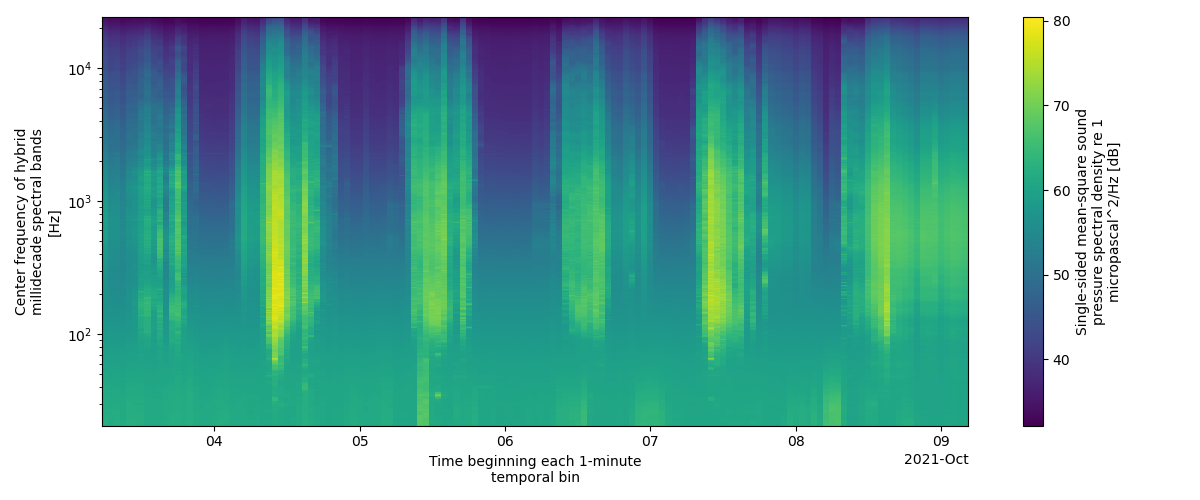

In [32]:
# Plot resampled sound data
ds.psd.plot(x='time', yscale='log')
plt.show()

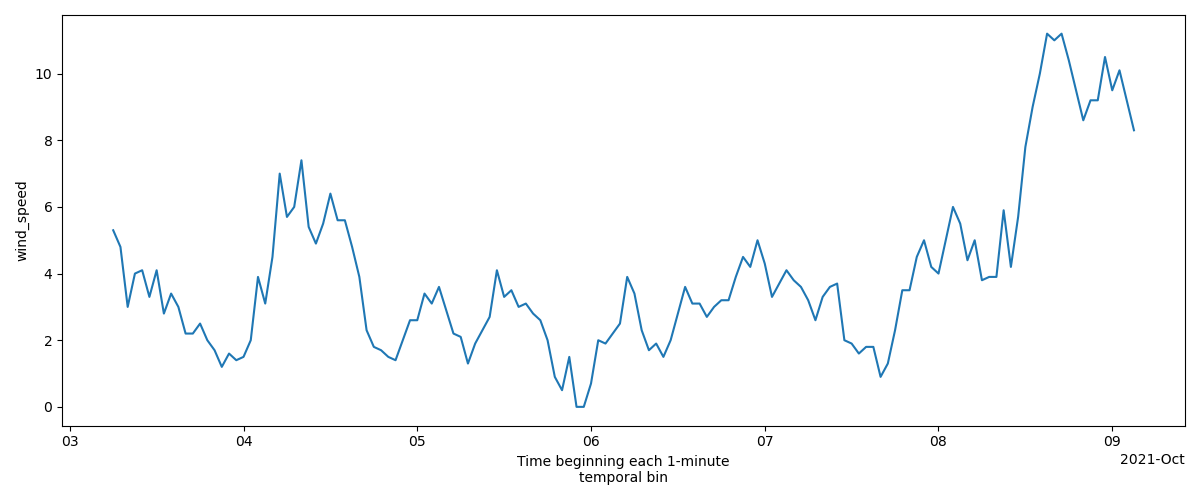

In [33]:
# Plot resampled wind data
ds[wind_var].plot()
plt.show()

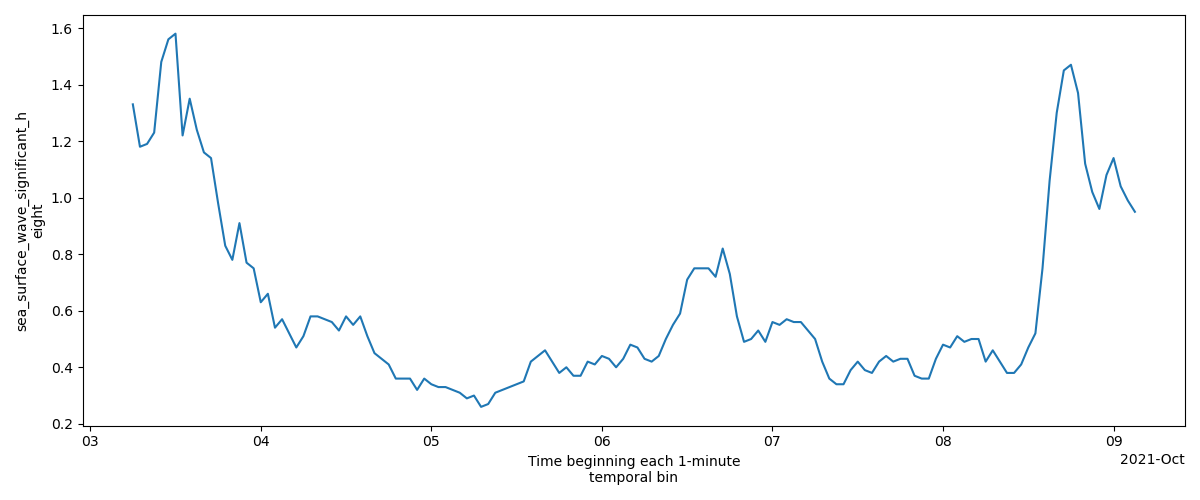

In [34]:
# Plot resampled wave data
ds[wave_var].plot()
plt.show()

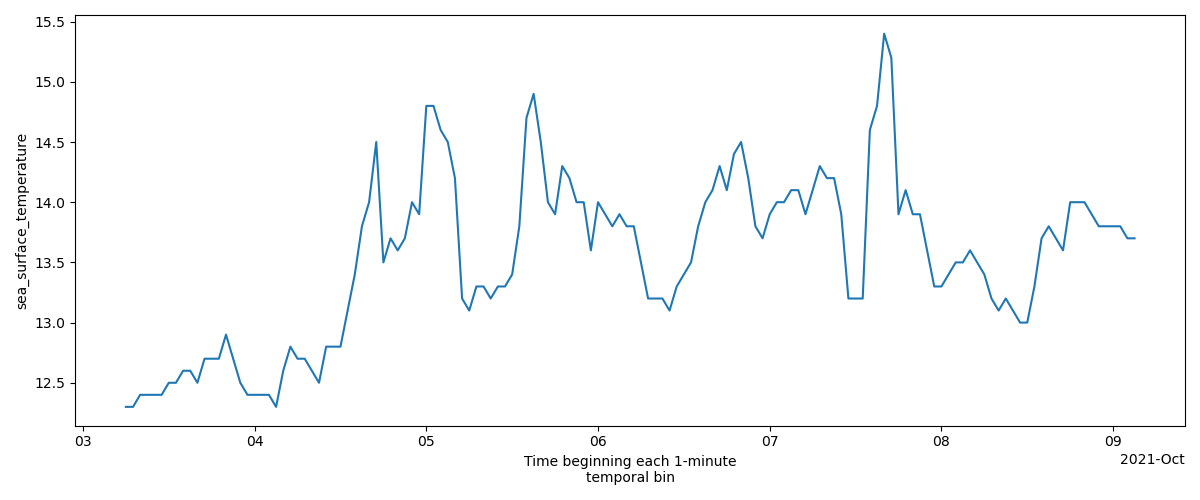

In [35]:
# Plot resampled water temperature data
ds[swt_var].plot()
plt.show()

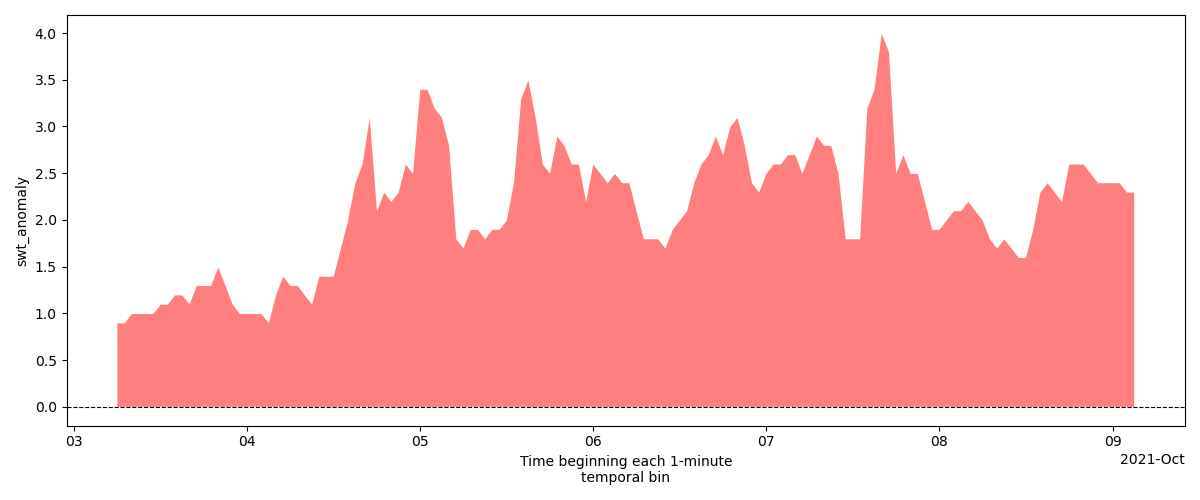

In [36]:
# Plot water temperature anomaly data
ds[anomaly_var].plot(linestyle='')
plt.fill_between(ds.time, ds[anomaly_var], 0, where=(ds[anomaly_var] < 0), facecolor='blue', alpha=0.5)
plt.fill_between(ds.time, 0, ds[anomaly_var], where=(ds[anomaly_var] >= 0), facecolor='red', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.show()

## Plot power spec

In [37]:
def plot_power_spec(
    ds, 
    conditions=None,
    title=None,
    xlabel='Frequency (hz)', 
    ylabel='Sound pressure level (db)', # use netcdf attribute
    envelope=True
):
    """
    Produces power spec plot given zero or more conditions and labels

    Args:
        ds: An Xarray Dataset consisting of both sound and environmental variables.
        conditions (optional): A single tuple or list of tuples, where each tuple is 
            a condition-label pair, the condition representing a conditional statement to
            be passed to ds.where() and each label representing that condition's legend label.
        title (optional): The plot title.
        xlabel (optional): The X-axis label.
        ylabel (optional): The Y-axis label.
        envelope (optional): Whether or not to plot the 10th to 90th quantile envelope
    """
    fig, ax = plt.subplots()

    # If no conditions were specified, just plot everything
    if conditions is None:
        ds.psd.median(dim='time').plot(x='frequency', xscale='log', ax=ax)

        # Add 10th to 90th quantile envelope
        if envelope:
            plt.fill_between(
                ds.frequency,
                ds.psd.chunk(dict(time=-1)).quantile(0.9, dim='time'),
                ds.psd.chunk(dict(time=-1)).quantile(0.1, dim='time'),
                alpha=0.25
            )

    else:

        # If conditions is a tuple (i.e. a single condition), wrap it in a list so it's iterable
        if isinstance(conditions, tuple):
            conditions = [conditions]

        # Plot each condition in turn
        for c, l in conditions:

            da = ds.where(c, drop=True).psd

            # Only plot if result of where operation has data
            if len(da) > 0:
                da.median(dim='time').plot(x='frequency', xscale='log', ax=ax, label=l)

                # Add 10th to 90th quantile envelope
                if envelope:
                    plt.fill_between(
                        da.frequency,
                        da.chunk(dict(time=-1)).quantile(0.9, dim='time'),
                        da.chunk(dict(time=-1)).quantile(0.1, dim='time'),
                        alpha=0.25
                    )

        ax.legend()
    
    if title is not None:
        ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.show()


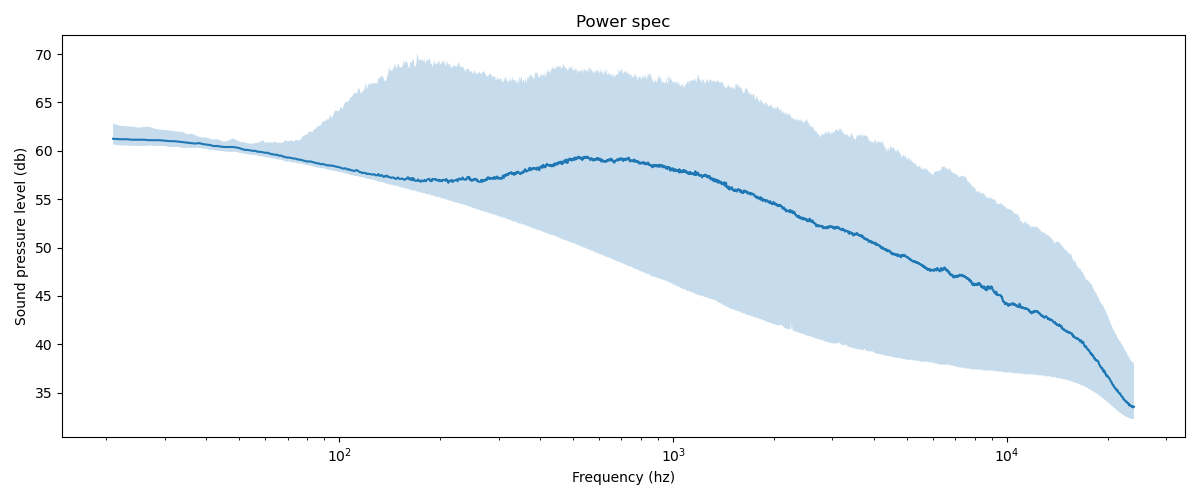

In [38]:
# Plot everything
plot_power_spec(ds, title='Power spec')

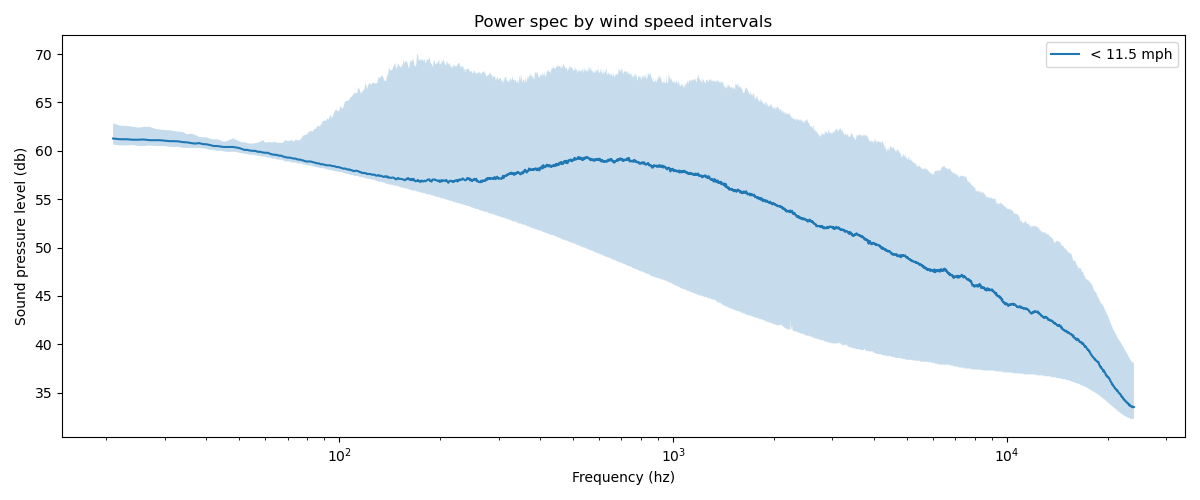

In [39]:
# Plot wind speed intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wind_var] <= 11.5, '< 11.5 mph'),
        ((ds[wind_var] > 11.5) & (ds[wind_var] <= 23), '> 11.5 mph, < 23 mph'),
        (ds[wind_var] > 23, '> 23 mph')
    ],
    title='Power spec by wind speed intervals'
)

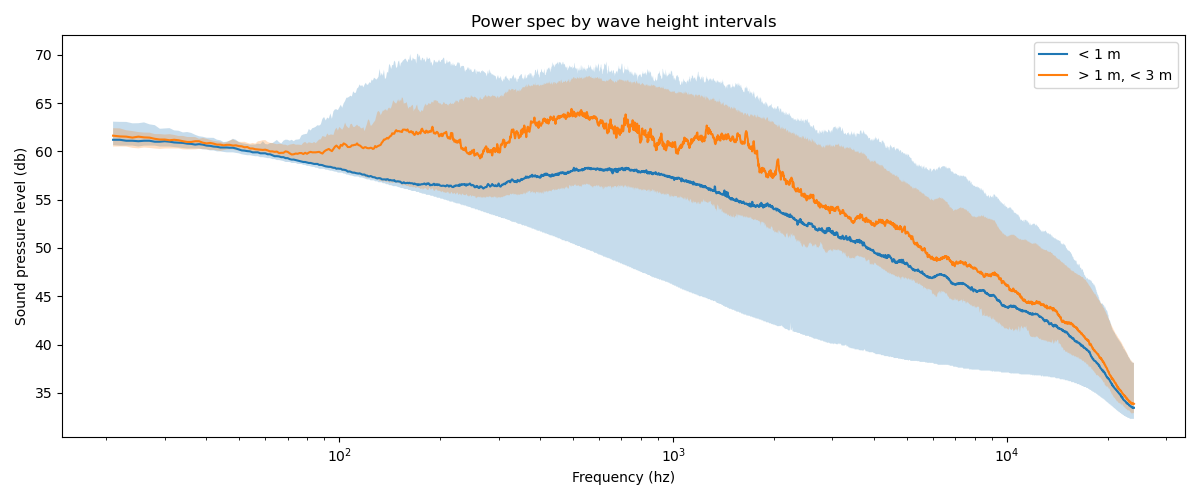

In [40]:
# Plot waves height intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[wave_var] <= 1, '< 1 m'),
        ((ds[wave_var] > 1) & (ds[wave_var] <= 3), '> 1 m, < 3 m'),
        (ds[wave_var] > 3, '> 3 m')
    ],
    title='Power spec by wave height intervals'
)

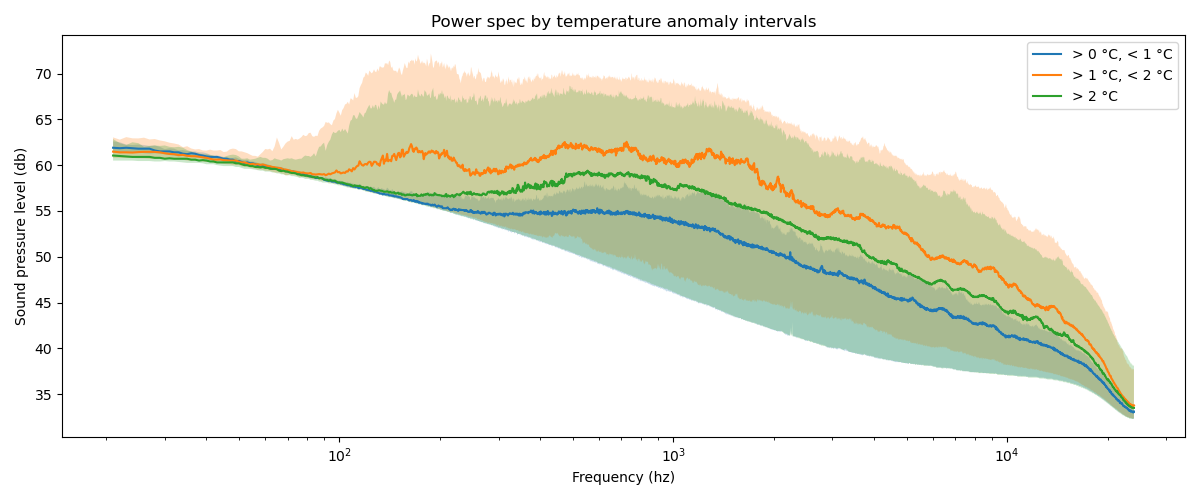

In [41]:
# Plot temperature anomaly intervals
plot_power_spec(
    ds,
    conditions=[
        (ds[anomaly_var] <= 0, '< 0 °C'),
        ((ds[anomaly_var] > 0) & (ds[anomaly_var] <= 1), '> 0 °C, < 1 °C'),
        ((ds[anomaly_var] > 1) & (ds[anomaly_var] <= 2), '> 1 °C, < 2 °C'),
        (ds[anomaly_var] > 2, '> 2 °C')
    ],
    title='Power spec by temperature anomaly intervals'
)